In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pickle

from pathlib import Path
from tqdm.auto import tqdm

In [7]:
import sys
sys.path.append('..')

In [8]:
from lib.models import HMM, HMMFilter
from lib.policies import StaticRoutingPolicy, MinimalDelayRoutingPolicy
from lib.policies import StaticMonitoringPolicy, RecedingHorizonPolicy
from lib.simulator import Scenario, Simulator

In [9]:
# scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/2_paths/')
# scenarios_paths = [x for x in scenarios_dir.iterdir() if x.is_dir()]

In [18]:
olivier_scenarios = [
#     '2_paths/Paris_Tokyo',
#     '3_paths/Singapore_HongKong',
#     '4_paths/Haifa_Santiago',
#     '4_paths/Paris_Santiago'
    '9_paths/Melbourne_Santiago'
]


scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/')
scenarios_paths = [scenarios_dir.joinpath(x) for x in olivier_scenarios]

In [ ]:
benchmarks = {}

# Progress bar
p = tqdm(scenarios_paths)

series_temp={}
for scenario_path in p:
    if scenario_path!='.ipynb_checkpoints':
        scenario = Scenario.from_path(scenario_path)
        # en scenario.timeseries tengo las series temporales para cada ruta
        series_temp[scenario.name]=scenario.timeseries
        print(scenario.timeseries[0])
        benchmark = {'logs': {}}

        # Constant monitoring cost
        costs = np.ones(scenario.n_paths) * 0.5

        # (Routing Policy, Monitoring Policy)
        policies = []

        # IP Path
        policies.append((
            StaticRoutingPolicy(0),
            StaticMonitoringPolicy(np.zeros(scenario.n_paths))
        ))

        # Receding Horizon
        policies.append((
            MinimalDelayRoutingPolicy(),
            RecedingHorizonPolicy(scenario.models, costs, τ_max=100, ρ=0.9, H=2, one_route=False)
        ))

        for routing_policy, monitoring_policy in policies:
            policy_name = '{} / {}'.format(routing_policy, monitoring_policy)
            p.set_description('{} ({})'.format(scenario.name, policy_name))

            try:
                sim = Simulator(scenario.timeseries, scenario.models, costs)
                print(sim.timeseries)
                benchmark['logs'][policy_name] = sim.benchmark(monitoring_policy, routing_policy)
            except Exception as e:
                print('Failed to simulate {}'.format(policy_name))
                print(e)

        benchmarks[scenario.name] = benchmark


[468.768 474.019 471.672 ... 465.761 469.048 468.315]


In [ ]:
# tengo las series temporales en scenario.timeseries[ruta]
for scenario, benchmark in benchmarks.items():
    series_temp[scenario.name]=scenario.timeseries

################################
# armo vector de entrenamiento #
################################

# serie es la ruta ideal (ruta 0, ruta 1, ruta 2) y serie_mod es el valor del RTT
serie=[]
serie_mod=[]
# serie_ent[i] es la ruta i para entrenamiento
serie_ent=[[],[],[]]
for i in range(largo_ent-T+1):
    for k in range(T):
        serie.append(np.argmin(rutas_mod[:,i+k]))
        serie_mod.append(min(rutas_mod[:,i+k]))
#         serie_1.append(rutas_mod[0][i])
#         serie_2.append(rutas_mod[1][i])
        for j in range(len(rutas)):
            serie_ent[j].append(rutas_mod[j][i])

print(len(serie_ent[1]), len(serie_ent[2]), len(serie))
# print(serie_1)
# print(serie)
# print(serie_mod)
# print(rutas_mod[0])
# print(rutas_mod[1])

tiempo=list(range(T))*int(largo_ent-T+1)
print(len(tiempo))



In [ ]:
measures = {'tiempo': tiempo, 'ruta 1': serie_ent[0], 'ruta 2': serie_ent[1], 'ruta 3': serie_ent[2], 'ruteo': serie}

df = pd.DataFrame(measures,columns= ['tiempo', 'ruta 1', 'ruta 2', 'ruta 3', 'ruteo'])
print (df)

In [ ]:
X = df[['tiempo', 'ruta 1', 'ruta 2', 'ruta 3']]
y = df['ruteo']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))

In [ ]:
# tengo que ver como armar el vector de entrada para realizar las predicciones
prediction=[]
# print(len(rutas_mod[1]))
for i in range(largo_test):
    [ruta]=clf.predict([[i%T, rutas_mod[0][largo_ent+(i-i%T)], rutas_mod[1][largo_ent+(i-i%T)], rutas_mod[2][largo_ent+(i-i%T)]]])
    # si elijo la ruta 1
#     print(ruta)
    prediction.append(rutas_mod[ruta][largo_ent+i])

costo_medida_T=(largo_test/T)*costs[0]

In [7]:
# infile = open('DatosH3_NOoneroute.pickle','rb')
# benchmarks = pickle.load(infile)
# infile.close()
#print(new_dict)

Paris_Tokyo
{'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fd464094c50>, 'Minimal Delay / RH(ρ=0.99,H=1)': <lib.simulator.Logbook object at 0x7fd46406a8d0>}}
[249.121 249.061 249.072 ... 247.613 247.601 247.675]
[247.214 246.946 247.162 ... 248.791 250.347 248.803]


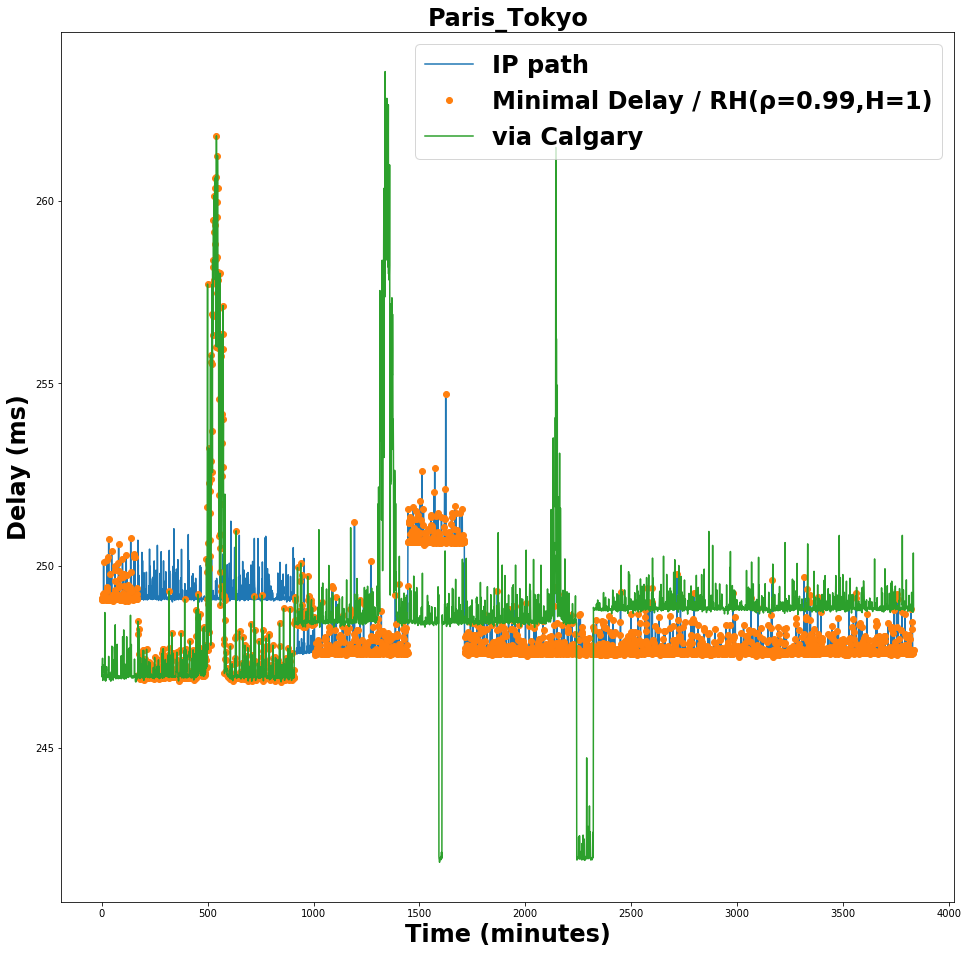

In [25]:
# print(scenario.models)
# print(sim.timeseries)
legend_properties = {'weight':'bold', 'size':'24'}
proxies={'Paris_Tokyo': ['IP path', 'via Calgary'], 'Singapore_HongKong': ['IP path', 'via Tokyo', 'via Narita'], 'Haifa_Santiago': ['IP path', 'via Curitiva', 'via Dublin', 'via Boston'], 'Paris_Santiago': ['IP path', 'via Cocoa', 'via Boston', 'via Dublin']}
for scenario, benchmark in benchmarks.items():
    print(scenario)
    print(benchmark)
    fig=plt.figure(figsize=(16,16))
    ax=fig.add_subplot(1,1,1)
    for policy, log in benchmark['logs'].items():
#         print(policy)
#         print(log)
        if policy=='Static Route 0 / Never Measure':
            ax.plot(log.get('delay'), label='IP path')
        else:
            ax.plot(log.get('delay'), 'o', label=policy)
    print(series_temp[scenario][0])
    for paths in range(1, len(proxies[scenario])):
        print(series_temp[scenario][paths])
        ax.plot(series_temp[scenario][paths], label=proxies[scenario][paths])
    ax.set_xlabel('Time (minutes)', fontsize=24, weight='bold')
    ax.set_ylabel('Delay (ms)', fontsize=24, weight='bold')
    ax.set_title(str(scenario), fontsize=24, weight='bold')
    plt.legend(prop=legend_properties)
    plt.savefig('Delay'+str(scenario)+'.pdf')
#     plt.show()

In [9]:
# print(scenario.models)
# print(sim.timeseries)
for scenario, benchmark in benchmarks.items():
    print(scenario)
#     print(benchmark['logs'].items())
    for policy, log in benchmark['logs'].items():
        gap=0
        no_min=0
        delay=log.get('delay')
        minimo=[]
#         minimo=delay
#         print(minimo)
        for i in range(len(delay)):
            menor=False
            minimo.append(delay[i])
            for j in range(len(series_temp[scenario])):
                if delay[i]>series_temp[scenario][j][i]:
                    menor=True
                    minimo[i]=series_temp[scenario][j][i]
            gap+=(delay[i]-minimo[i])/minimo[i]
            if menor==True:
                no_min+=1
        print(policy, 1-no_min*1./len(delay), gap*1./len(delay))

Paris_Tokyo
Static Route 0 / Never Measure 0.6810951760104302 0.0030903699364293806
Minimal Delay / RH(ρ=0.99,H=1) 0.8083441981747066 0.0021790015708144524


In [10]:
def get_benchmark_df(benchmarks):
    records = []

    for scenario, benchmark in benchmarks.items():
        for policy, log in benchmark['logs'].items():
            records.append({
                'scenario': scenario,
                'policy': policy,
                'avg_delay': log.avg_delay(),
                'avg_cost': log.avg_cost(),
                'avg_processing_time': log.avg_processing_time() / 1e3,
                'avg_n_measures': log.avg_n_measures()
            })

    return pd.DataFrame.from_records(records)

In [11]:
get_benchmark_df(benchmarks)

,avg_cost,avg_delay,avg_n_measures,avg_processing_time,policy,scenario
0,0.000000,248.308882,0.000000,2.709040,Static Route 0 / Never Measure,Paris_Tokyo
1,0.001173,248.084757,0.002347,1554.230868,"Minimal Delay / RH(ρ=0.99,H=1)",Paris_Tokyo


In [18]:
import pickle
filename = 'Paris_Tokyo'
outfile = open(filename,'wb')
pickle.dump(benchmarks,outfile)
outfile.close()

In [12]:
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()
print(new_dict)

{'Haifa_Santiago': {'logs': {'Static Route 0 / Never Measure': <lib.simulator.Logbook object at 0x7fc53c1a3590>, 'Minimal Delay / RH(ρ=0.99,H=3)': <lib.simulator.Logbook object at 0x7fc535f1aa10>}}}


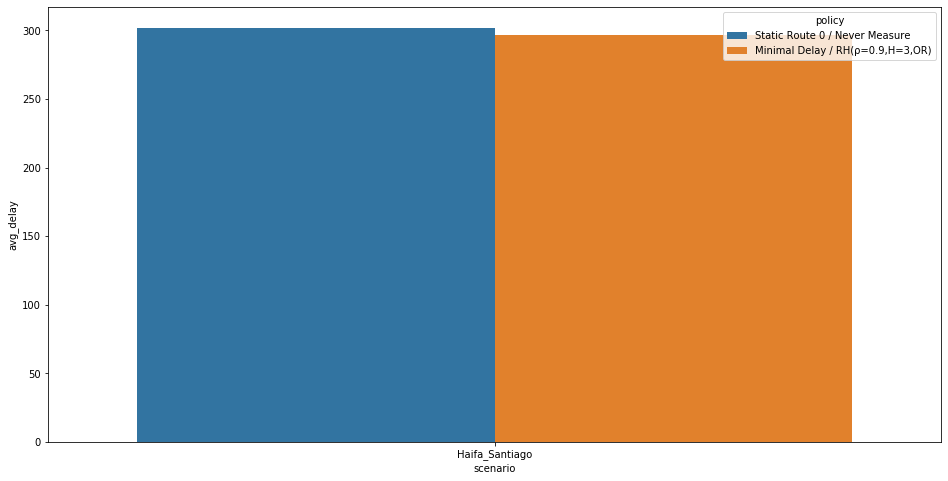

In [60]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_delay', hue='policy', data=df)
# plt.savefig('../figures/benchmark_delay_v2.png', bbox_inches='tight', dpi=300)

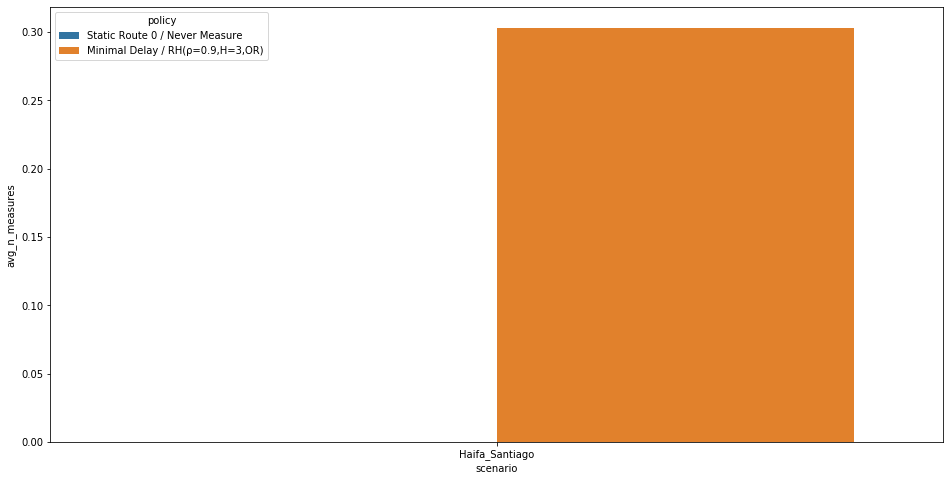

In [61]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_n_measures', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

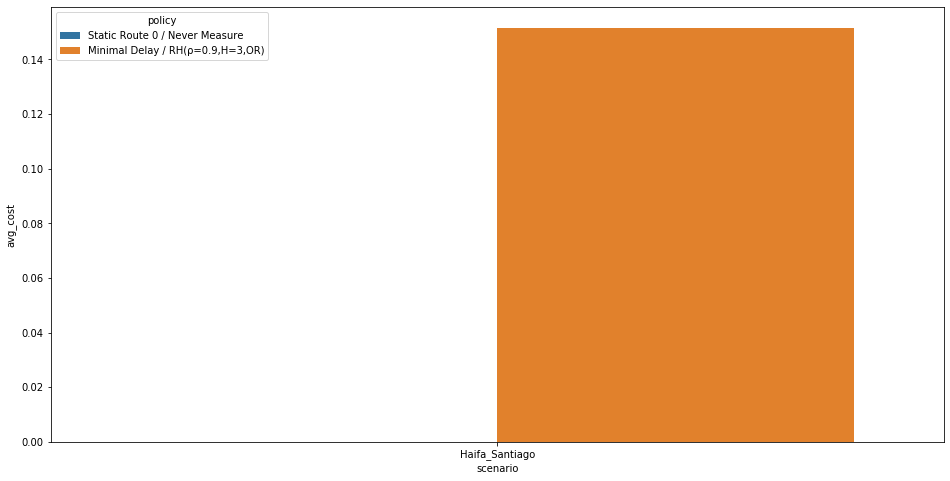

In [62]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_cost', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

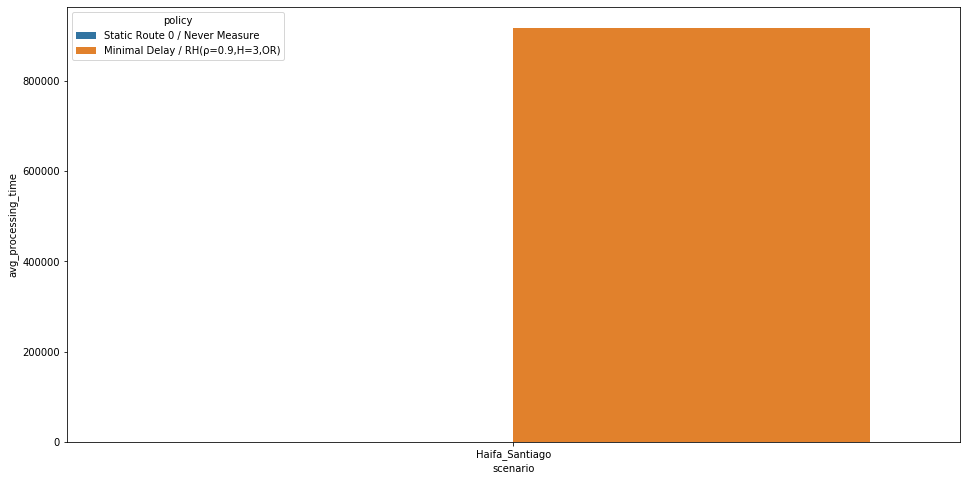

In [63]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_processing_time', hue='policy', data=df)
# plt.savefig('../figures/benchmark_acc_v2.png', bbox_inches='tight', dpi=300)